# 画像解析用プログラム
以下では、ImageJ で得られた`.csv`データを用いて、ビーカーのデータに対しては輝度の時間変化及びそのフーリエ解析を行い、シャーレのデータに対しては輝度の空間変化及びそのフーリエ解析を行います。

In [1]:
# ライブラリーの読み込み
# はじめに必要なライブラリーを読み込みます。
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ビーカーの輝度値とその時間変換の解析

### CSV データの読み込み
まずはじめに ImageJ により得られた`.csv`ファイルを、Python の `Pandas` ライブラリーにより読み込みます。

In [2]:
beaker_csv_file = 'bz_beaker.csv' # ビーカーのczvファイル名(適宜自分自身のファイル名に変更してください)
beaker_df = pd.read_csv(beaker_csv_file) # ビーカーのデータを読み込む
beaker_df.head() # データの確認

,Slice,Mean
0,1,16.5275
1,2,17.0769
2,3,17.8571
3,4,18.2418
4,5,19.2967


### Slice から 実時間に変換
ImageJ により得られた`.csv`ファイルの中身を確認すると、`Slice`, `Mean`の２つが得られていると思います。

`Mean`とは、ImageJ にて長方形内の平均輝度値を求めるようにした場合に得られる、長方形内の平均輝度値です。  
また、ImageJ における解析は動画の１フレームごとに行われるため、`Slice`はフレーム番号に対応します。
そのため、`Slice`から実時間に変換するには、以下の式で変換する必要があります。

実時間 (s) = `Slice` × 倍速率 / フレームレート

ここで、倍速率は ffmpeg にて変換時にメモしたものを使用してください。(デフォルトは4倍)  
また、フレームレートは元動画のプロパティから確認してください。(デフォルトは30fps)

In [3]:
# 変換時のパラメータ設定 (fps: フレームレート, speed: 倍速率, 自分のデータに合わせて変更してください)
fps = 30 # フレームレート (デフォルト)
speed = 4.0 # 倍速率 (デフォルト)

# 実時間を計算し、新しい列に追加する
beaker_df.insert(1, 'time', beaker_df['Slice']*speed/fps)

# データの確認
beaker_df.head()

,Slice,time,Mean
0,1,0.133333,16.5275
1,2,0.266667,17.0769
2,3,0.400000,17.8571
3,4,0.533333,18.2418
4,5,0.666667,19.2967


### ビーカーの輝度値の時間変化のプロット
以上のようにデータに対する前処理が完了したので、次に Python の `Matplotlyb` ライブラリーにより、グラフを折れ線グラフとして可視化します。

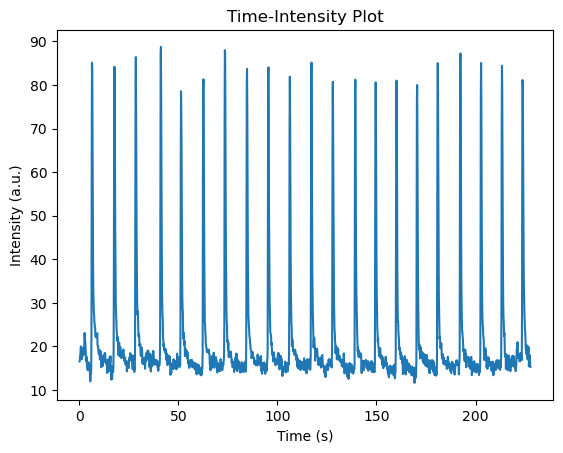

In [4]:
# データを折れ線グラフで可視化する
plt.plot(beaker_df['time'], beaker_df['Mean']) # 折れ線グラフの作成
plt.xlabel('Time (s)') # x軸のラベル
plt.ylabel('Intensity (a.u.)') # y軸のラベル
plt.title('Time-Intensity Plot') # グラフのタイトル
plt.show()

### 輝度値の時間変化データのフーリエ解析
ビーカーで測定した輝度値の時間変化をフーリエ変換することにより、振動の周波数などの振動や揺らぎに関する情報を得ることができます。  
Python では、`numpy` というライブラリーによりフーリエ変換を行うことが可能です。  

フーリエ変換に関する詳しい内容は、書籍やネット上の解説記事等を参考にして、何を実行しているのか理解するようにしましょう。

In [5]:
# フーリエ変換
N = len(beaker_df['Mean']) # データ数 (FFT を行うにはデータ数が2のべき乗である必要があるが、そうでなくても良い)
dt = np.mean(np.diff(beaker_df['time'])) # サンプリング間隔
freq = np.fft.fftfreq(N, dt) # 周波数軸の作成
ft_values = np.fft.fft(beaker_df['Mean']) # フーリエ変換 (複素数値が得られる)
ft_abs_values = np.abs(ft_values) # 振幅 (複素数を絶対値に変換)
ft_power_spectrum = ft_abs_values**2 # パワースペクトル

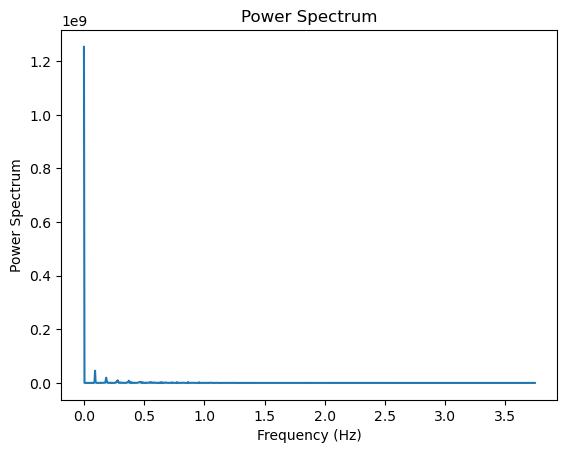

In [6]:
# パワースペクトルをプロット
plt.plot(freq[:N//2], ft_power_spectrum[:N//2]) # パワースペクトルのプロット
# N//2 は、ナイキスト周波数までのデータを表示するための処理
plt.xlabel('Frequency (Hz)') # x軸のラベル
plt.ylabel('Power Spectrum') # y軸のラベル
plt.title('Power Spectrum') # グラフのタイトル
plt.show()

パワースペクトルは、対数軸としてみると見やすいので以下のように、縦軸を `log` スケールにしましょう。

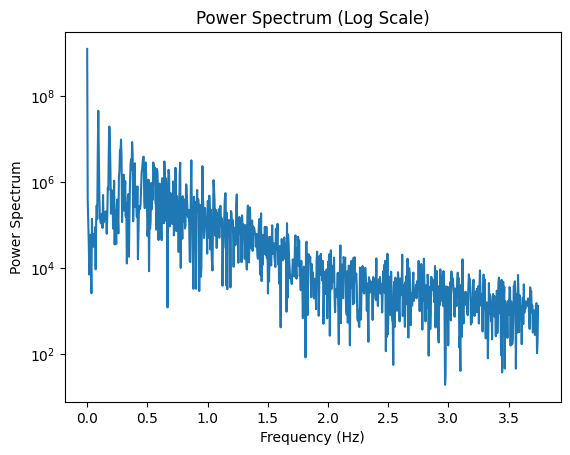

In [14]:
# パワースペクトルの対数プロット
plt.plot(freq[:N//2], ft_power_spectrum[:N//2])
plt.yscale('log') # y軸を対数スケールに変更
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum (Log Scale)')
plt.show()

## シャーレの輝度値と空間変化の解析

### csv データの読み込み
先ほどと同様、まず csv データを読み込みます。

In [10]:
# csv ファイルの読み込み
dish_csv_file = 'bz_dish.csv' # ビーカーのczvファイル名(適宜自分自身のファイル名に変更してください)
dish_df = pd.read_csv(dish_csv_file) # ビーカーのデータを読み込む
dish_df.head() # データの確認

,Distance_(pixels),Gray_Value
0,0,111.0000
1,1,115.0010
2,2,117.1073
3,3,117.9703
4,4,117.7939


### Distance_(pixels) から 実空間に変換
`.csv`ファイルの中身を確認すると、`Distance_(pixels)`, `Gray_value`の２つが得られていると思います。

`Gray_value`とは、ImageJ 上で解析を行ったときの解析点における輝度値です。  
また、`Distance_(pixels)`とは、ImageJ 上で解析を行うときには画像上のピクセル単位で行うため、画像上の１ピクセルが、何cm に対応するのかを先に知る必要があります。  
それを得たうえで、`Distance_(pixels)` を実空間に変換するには、以下の式のように行います。

実空間 (cm) = `Distance_(pixels)` × `rate`(cm/pixel)

In [11]:
# 変換時のパラメータ設定 (rate : cm/pixel)
# このパラメータは、自分で画像解析を行った結果に基づいて設定してください。
rate = 0.016657416

# 実空間上の距離を計算し、新しい列に追加する
dish_df.insert(1, 'distance', dish_df['Distance_(pixels)']*rate)

# データの確認
dish_df.head()

,Distance_(pixels),distance,Gray_Value
0,0,0.000000,111.0000
1,1,0.016657,115.0010
2,2,0.033315,117.1073
3,3,0.049972,117.9703
4,4,0.066630,117.7939


### 輝度値の空間変化のプロット
先ほどと同様に、前処理が完了したデータに対して、折れ線グラフにより可視化します。

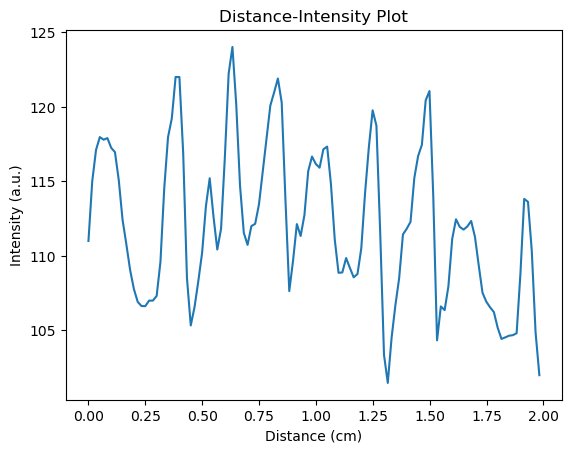

In [12]:
plt.plot(dish_df['distance'], dish_df['Gray_Value']) # 折れ線グラフの作成
plt.xlabel('Distance (cm)') # x軸のラベル
plt.ylabel('Intensity (a.u.)') # y軸のラベル
plt.title('Distance-Intensity Plot') # グラフのタイトル
plt.show()

### 輝度値の空間変化のフーリエ解析
ビーカーで測定した輝度値の時間変化に対してフーリエ変換を行ったのと同様に、シャーレで測定した輝度値の空間変化に対しても、波数空間上にフーリエ変換を行うことで、振動やゆらぎに関する情報が得られる。

こちらについても詳しくは、書籍やネット上の解説記事等を参考にしてください。

In [13]:
# フーリエ変換
N = len(dish_df['Gray_Value']) # データ数 (FFT を行うにはデータ数が2のべき乗である必要があるが、そうでなくても良い)
dx = np.mean(np.diff(dish_df['distance'])) # 空間サンプリング間隔
k = np.fft.fftfreq(N, dx) * 2 * np.pi / rate # 波数軸の作成
ft_values = np.fft.fft(dish_df['Gray_Value']) # フーリエ変換 (複素数値が得られる)
ft_abs_values = np.abs(ft_values) # 振幅 (複素数を絶対値に変換)
ft_power_spectrum = ft_abs_values**2 # パワースペクトル

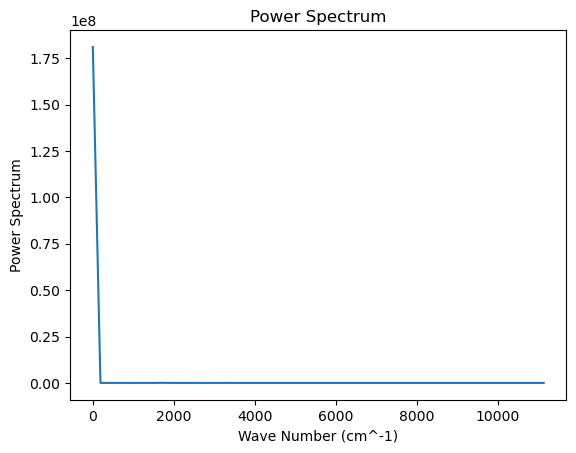

In [14]:
# パワースペクトルをプロット
plt.plot(k[:N//2], ft_power_spectrum[:N//2]) # パワースペクトルのプロット
# N//2 は、ナイキスト周波数までのデータを表示するための処理
plt.xlabel('Wave Number (cm^-1)') # x軸のラベル
plt.ylabel('Power Spectrum') # y軸のラベル
plt.title('Power Spectrum') # グラフのタイトル
plt.show()

パワースペクトルは、対数軸としてみると見やすいので以下のように、縦軸を `log` スケールにしましょう。

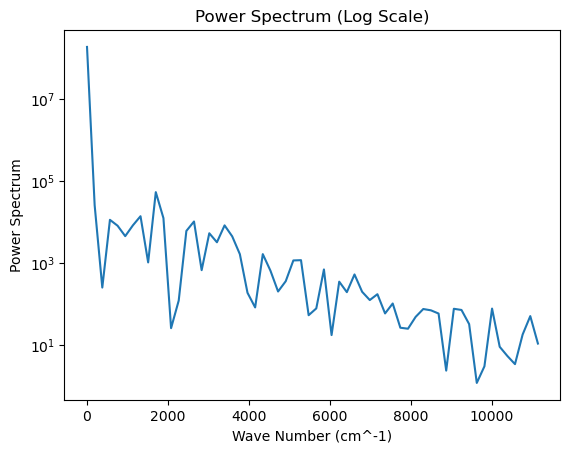

In [15]:
# パワースペクトルの対数プロット
plt.plot(k[:N//2], ft_power_spectrum[:N//2])
plt.yscale('log') # y軸を対数スケールに変更
plt.xlabel('Wave Number (cm^-1)')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum (Log Scale)')
plt.show()